In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from joblib import Parallel, delayed
from IPython.display import clear_output

import warnings

warnings.filterwarnings('ignore')


1. RateConst Reader


In [2]:
def getAllRateInfo(file):   
    res=pd.DataFrame()
    try:
        temp=pd.read_csv(file)
        temp=temp.dropna()
        temp['Protein']=file.split('\\')[-1].replace('.RateConst.csv','')
        res=pd.concat([res,temp])
    except Exception as exp:
        return res
    
    return res
def getAllRate(data_path):
    results = Parallel(n_jobs=-1)(delayed(getAllRateInfo)(file) for file in [os.path.join(data_path,x) for x in os.listdir(data_path) if '.RateConst.csv' in x  ]) 
    all_data=pd.concat(results)
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

2. Quant File Reader

In [3]:
def read_n_merge(skip,file):
    file_data=pd.read_csv(file,skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.split('\\')[-1].replace('.Quant.csv','') 
        return [isparsed,file_data]
    else:
        return [isparsed,None]
def get_df_all_quant_files(file):
    res=read_n_merge(1,file)
    all_data=None
    if res[0]: all_data=res[1]
    else: all_data=read_n_merge(3,file)[1]
    return all_data

def getquantfile(data_path):
    results = Parallel(n_jobs=-1)(delayed(get_df_all_quant_files)(file) for file in [os.path.join(data_path,x) for x in os.listdir(data_path) if '.Quant.csv' in x  ])
    all_data=pd.concat(results)
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

3. Data source & path

In [4]:
# organ="liver"
organ="heart"
# organ="muscle"
# data_path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_liver'
data_path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_heart'
# data_path=r'H:\Warehouse\Data\DataUsedForPublication\Partial IsotopeProfile paper data used for publication\liverpool_CI\muscle'


data_quant=getquantfile(data_path)
data_rate=getAllRate(data_path)
data_rate=data_rate[(data_rate.Rsquared!=' -nan(ind)')&(data_rate.Rsquared!=' ')]



4. merge quant and rate files

In [5]:
merged=pd.merge(data_quant,
                data_rate,
                left_on=['Protein','Peptide','Charge'],
                right_on=['Protein','Peptides','Charge'])
merged=merged.reset_index(drop=True)
merged.shape

(13520, 217)

5. parameters

In [6]:
pw,ph=0.046,1.5574E-4
# rsquared= 0.99
maxrate=math.log(2)
exp_time=[0 ,1 ,2 ,3 ,6 ,7 ,9 ,13,16,21,24,31]

6. filter data

In [7]:
merged=merged[#(merged.Rsquared.astype('float')>=rsquared) &
              (merged.RateConstants< math.log(2))]
merged=merged.reset_index(drop=True)
merged.shape

(13240, 217)

7. Helper functions

In [38]:
def get_I0_t(I0_0,I0_asymp,k,t):
    return I0_asymp + (I0_0-I0_asymp)*math.exp(-k*t)

def get_I0_asmyp(I0_0,neh):
    return I0_0*( (1 - pw/(1-ph))**neh )

def get_I0_exp(index,suffix):
    _sum=float(float(merged.loc[index,f'I0{suffix}'])+float(merged.loc[index,f'I1{suffix}'])+float(merged.loc[index,f'I2{suffix}'])+float(merged.loc[index,f'I3{suffix}'])+
                        float(merged.loc[index,f'I4{suffix}'])+float(merged.loc[index,f'I5{suffix}']))
    if _sum==0: return None
    else: return float(merged.loc[index,f'I0{suffix}'])/_sum

def getNewKestimate(M0_0,I0_0_exp,I0_asymp,t,I0_t_exp,numberofTerms): 
        
    base=(I0_0_exp-I0_t_exp)/(M0_0-I0_asymp)    
    new_kt= sum([ (base**i)/i for i in range(1,numberofTerms+1)])     
    new_k=new_kt/t    
    return new_k


def getNewKestimateByIndex(time,numberofterms,index):
        
        time_index=exp_time.index(time)
        suffix=f".{time_index}"  
        # print('time',time,time_index)
                                              
        if merged.loc[index,f'I0{suffix}'] == ' ' or merged.loc[index,f'I0'] == ' ': 
            return None            
        
        I0_0_exp= get_I0_exp(index,"")
        I0_t_exp=get_I0_exp(index,suffix)
        
        if I0_0_exp == None or I0_t_exp ==None or  I0_t_exp >  I0_0_exp: 
            return None

        M0_0=float(merged.loc[index,f'M0'])/100
        k=float(merged.loc[index,f'RateConstants'])
        I0_asymp=M0_0*( (1 - pw/(1-ph))**merged.loc[index,f'Exchangeable Hydrogens'] ) 
        i0_t_theo= I0_asymp + (M0_0-I0_asymp)*math.exp(-k*time)     
        
        exp_fsr= (I0_0_exp-I0_t_exp)/(M0_0-I0_asymp)
        # print(exp_fsr, (I0_0_exp-I0_t_exp),(M0_0-I0_asymp),"==>",(I0_0_exp,I0_t_exp),(M0_0,I0_asymp) )
        if exp_fsr > 1: return None
        exp_kt= -math.log( 1 - exp_fsr) 
        d2ome_kt=k*time
        
        error=   abs(exp_kt - d2ome_kt)/d2ome_kt

        return[merged.loc[index,'Protein'],
               merged.loc[index,'Peptide'],
               merged.loc[index,'Charge'],                
                    merged.loc[index,f'Exchangeable Hydrogens'],
                    M0_0,I0_0_exp,
                    I0_asymp,
                    I0_t_exp,i0_t_theo,k] +[getNewKestimate(M0_0,I0_0_exp,I0_asymp,time,I0_t_exp,numberofterms),error]
        
def computeAllNewRates(_time,_numberOfTerms):
    # res = Parallel(n_jobs=-1)(delayed(getNewKestimateByIndex)(_time,_numberOfTerms,index) for index in range(merged.shape[0]))
    res=[getNewKestimateByIndex(_time,_numberOfTerms,index) for index in range(merged.shape[0])]
    res=pd.DataFrame([r for r in res if r!=None])
    res.columns=['Protein','Peptide','Charge',"NEH","M0","I0_0_exp","I0_asmp",'i0_t_exp','i0_t_theo','d2ome_k','new_k','error']
    return res

def plot_hitmap(x,y,time,path="",title=""):
          
    plt.rc('font',size=14)
    plt.figure(figsize=(7,6))
    plt.set_cmap('jet')  
    
    x=np.array(x)
    y=np.array(y)    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    r=np.corrcoef(x,y)
    
    # Create the main plot
    _, ax1 = plt.subplots()


    cb=ax1.scatter(x, y, c=z, s=10,alpha=0.8)  
    ax1.plot(x,x,ls='-.',c='k',linewidth=1,alpha=0.5,label=f"n={len(list(x))}\nr={int(1000*r[0][1])/1000}")      
    cbar = plt.colorbar(cb)
    ax1.set_ylabel("k (Single time point)")
    ax1.set_xlabel("k (Time course data)")    
    ax1.legend()  
    # Remove top and right spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    # ax1.set_xlim([0,min(max(x),0.3)])
    # ax1.set_ylim([0,min(max(y),0.3)])
    
    
    # Create the second x-axis
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks([(i*time) for i in ax1.get_xticks()])
    ax2.set_xlabel('kt', color='k')
    ax2.spines['right'].set_visible(False)


    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}.jpeg",dpi=900)
        
    plt.show()
    
    
   
def plotRateRDDensity(res,path="",title=""):
    plt.rc('font',size=14)
    plt.figure(figsize=(8,6))
    rd_k= (res.d2ome_k - res.new_k)/res.d2ome_k
    ax=sns.histplot(rd_k, kde=True, #bins=50,
                label=f"n={len(rd_k)},μ = {int(100*np.mean(rd_k))/100}, \nmedian = {int(100*np.median(rd_k))/100}, \nsd = {int(100*np.std(rd_k))/100}",
                color='white',alpha=0.1,edgecolor=('black',0.75) )
    ax.lines[0].set_color('k')
    ax.lines[0].set_alpha(0.75) 
    ax.lines[0].set_ls(':') 
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel(r'$\frac{ k _{\:Time\: course\: data} - k _{\:Single\: time\: point}}{k _{\:Time\: course\: data}}$')
    plt.legend()
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}_RD_k.jpeg",dpi=900)
    plt.show()

8. Prepare all new k values

In [9]:
# _res=computeAllNewRates(1,1)
# plot_hitmap(_res.d2ome_k,_res.new_k)
# plotRateRDDensity(_res)
# plotI0_expRDDensity(_res)
# plotSubgroup(_res,"","",1)

In [10]:
allmerged=merged.copy()
allmerged.shape

(13240, 217)

In [11]:
# for _time in tqdm([1 ,2 ,3 ,6 ,7,13,16]):
#     for _rsquared in [0.99,0.95,0.9][::-1]:
#         for _numberofterms in (1,2,3,6,10):
                        
#             merged=allmerged.copy()
#             merged=merged[(merged.Rsquared.astype('float')>=_rsquared)]
#             merged=merged.reset_index(drop=True)
            
#             _res=computeAllNewRates(_time,_numberofterms)
#             _path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/"
#             _path2=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/subgroup/DenseRegion/"
#             _path3=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/subgroup/10Percent_K_RD/"
#             _paths=[_path1,_path2,_path3]
#             for _path in _paths[:1]:
#                 if not os.path.exists(_path): os.makedirs(_path)

#             _title=f"{organ}_day_{_time}_numberofterms_{_numberofterms}"    

#             plot_hitmap(_res.d2ome_k,_res.new_k,_time,_path1,_title)
#             plotRateRDDensity(_res,_path1,_title)
#             plotI0_expRDDensity(_res,_path1,_title)
#             # plotI0_I0_t_k_RDDensity(_res,_path1,_title)
#             # plotNEH_k_RDDensity(_res,_path1,_title)

#             clear_output(wait=True)  
#             # plotSubgroup(_res,_path2,_title,1)
#             # plotSubgroup(_res,_path3,_title,2)
            
#             _res.to_csv(_path1+_title+".csv",index=False)


In [19]:

_time=1
_rsquared=0.95
_numberofterms=10

_path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/"
_path2=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/subgroup/DenseRegion/"
_path3=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/subgroup/10Percent_K_RD/"
_paths=[_path1,_path2,_path3]
for _path in _paths:
    if not os.path.exists(_path): os.makedirs(_path)

            
merged=allmerged.copy()
merged=merged[(merged.Rsquared.astype('float')>=_rsquared)]
merged=merged.reset_index(drop=True)

_res=computeAllNewRates(_time,_numberofterms)

_res=_res[(_res.d2ome_k.astype('float')>=0)]
_res=_res[(_res.new_k.astype('float')>=0)]

_path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/"
_path2=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/subgroup/DenseRegion/"
_path3=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{_numberofterms}/subgroup/10Percent_K_RD/"
_paths=[_path1,_path2,_path3]
for _path in _paths:
    if not os.path.exists(_path): os.makedirs(_path)

_title=f"{organ}_day_{_time}_numberofterms_{_numberofterms}"    

# plot_hitmap(_res.d2ome_k,_res.new_k,_time,_path1,_title)


_title=""
_path1=""


In [20]:
# temp=_res.sort_values(by='error')
# temp=temp[temp.error<=0.2]
# plot_hitmap(temp.d2ome_k,temp.new_k,_time,_path1,_title)

In [27]:
_res.head(5)

,Protein,Peptide,Charge,NEH,M0,I0_0_exp,I0_asmp,i0_t_exp,i0_t_theo,d2ome_k,new_k,error,i0_d2ome,i0_new,fsr_d2ome,fsr_new,fsr_exp,rd_fsr,I0_0_RD
0,1433B_MOUSE,DSTLIMQLLR,2,16,0.48532,0.484339,0.228428,0.478628,0.467202,0.07314,0.022482,0.692616,0.466289,0.478649,0.070260,0.022146,0.022231,0.003835,-0.002022
1,1433B_MOUSE,EMQPTHPIR,2,21,0.50917,0.505778,0.189370,0.481511,0.488855,0.06563,0.078915,0.202420,0.485679,0.481768,0.062849,0.075076,0.075881,0.010721,-0.006662
2,1433B_MOUSE,EMQPTHPIR,3,21,0.50917,0.523931,0.189370,0.509042,0.489707,0.06279,0.047678,0.240674,0.503570,0.508354,0.063668,0.048708,0.046559,-0.044121,0.028991
3,1433E_MOUSE,YLAEFATGNDR,2,22,0.48396,0.495823,0.171713,0.466465,0.460999,0.07638,0.098739,0.292735,0.471989,0.465350,0.076330,0.097593,0.094021,-0.036602,0.024512
4,1433E_MOUSE,AAFDDAIAELDTLSEESYK,2,42,0.30297,0.313880,0.041908,0.290503,0.281570,0.08553,0.093814,0.096851,0.291586,0.289526,0.085400,0.093290,0.089548,-0.040115,0.036011


In [28]:
_res["i0_d2ome"]=[_res.I0_asmp[i] + (_res.I0_0_exp[i] - _res.I0_asmp[i])*math.exp(-_res.d2ome_k[i]*_time) for i in range(_res.shape[0])]
_res["i0_new"]=[_res.I0_asmp[i] + (_res.I0_0_exp[i] - _res.I0_asmp[i])*math.exp(-_res.new_k[i]*_time) for i in range(_res.shape[0])]

_res["fsr_d2ome"]=[ (_res.I0_0_exp[i] - _res.i0_d2ome[i])/(_res.M0[i] - _res.I0_asmp[i])  for i in range(_res.shape[0]) ]
_res["fsr_new"]=[ (_res.I0_0_exp[i] - _res.i0_new[i])/(_res.M0[i] - _res.I0_asmp[i])  for i in range(_res.shape[0]) ]
_res["fsr_exp"]=[ (_res.I0_0_exp[i] - _res.i0_t_exp[i] )/(_res.M0[i] - _res.I0_asmp[i])  for i in range(_res.shape[0]) ]

_res['rd_fsr']= (_res.fsr_exp-_res.fsr_new)/_res.fsr_new
_res['I0_0_RD']=(_res.I0_0_exp -_res.M0)/_res.M0
_res['I0_t_RD']=(_res.i0_t_exp -_res.i0_t_theo)/_res.i0_t_theo
allvals=_res.copy()

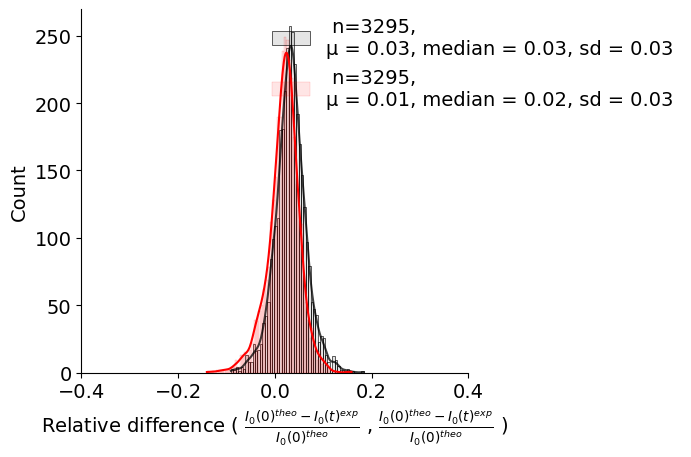

In [39]:
def plotRateRDDensity(rd_k,col,title=""):
    
    ax=sns.histplot(rd_k, kde=True, #bins=50,
                label=f"{title} n={len(rd_k)},\nμ = {int(100*np.mean(rd_k))/100}, median = {int(100*np.median(rd_k))/100}, sd = {int(100*np.std(rd_k))/100}",
                color=col,alpha=0.1,edgecolor=(col,0.75) )
    # ax.lines[0].set_color('k')
    ax.lines[0].set_alpha(0.75) 
    # ax.lines[0].set_ls(':') 
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel("Relative difference ( "+  r'$\frac{ I_{0}(0)^{theo} - I_{0}(t)^{exp} }{I_{0}(0)^{theo}}$' +" , " + r'$\frac{ I_{0}(0)^{theo} - I_{0}(t)^{exp} }{I_{0}(0)^{theo}}$'+ " )")
    plt.legend(bbox_to_anchor=(1.55, 1), loc='upper right', borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.xlim([-0.4,0.4])
    
# plt.scatter(abs(allvals.error),abs(allvals.I0_0_RD),c=abs(allvals.I0_0_RD))
# sns.histplot(allvals.I0_0_RD)
# sns.histplot(allvals.I0_t_RD)

plotRateRDDensity(allvals.I0_0_RD,'k',"")
plotRateRDDensity(allvals.I0_t_RD,'r',"")

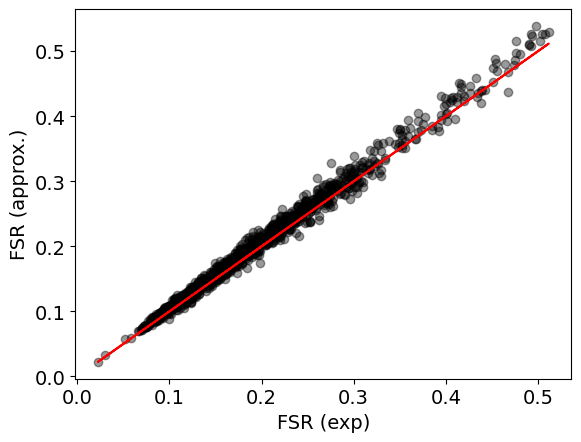

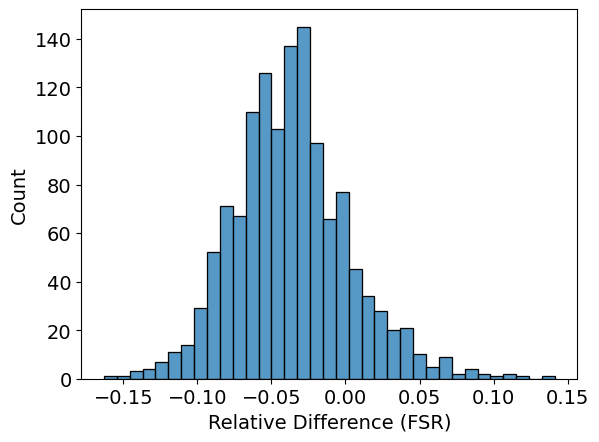

<Figure size 700x600 with 0 Axes>

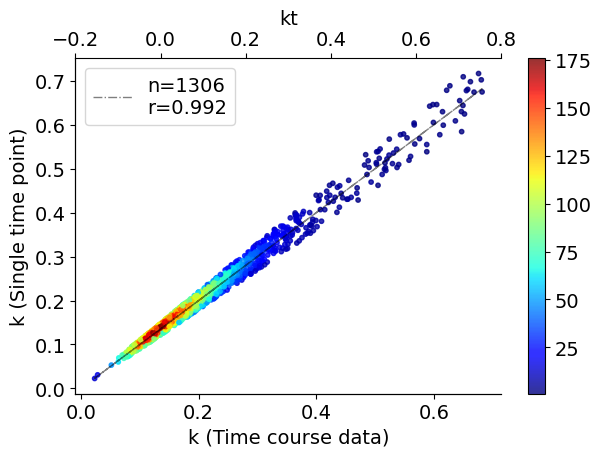

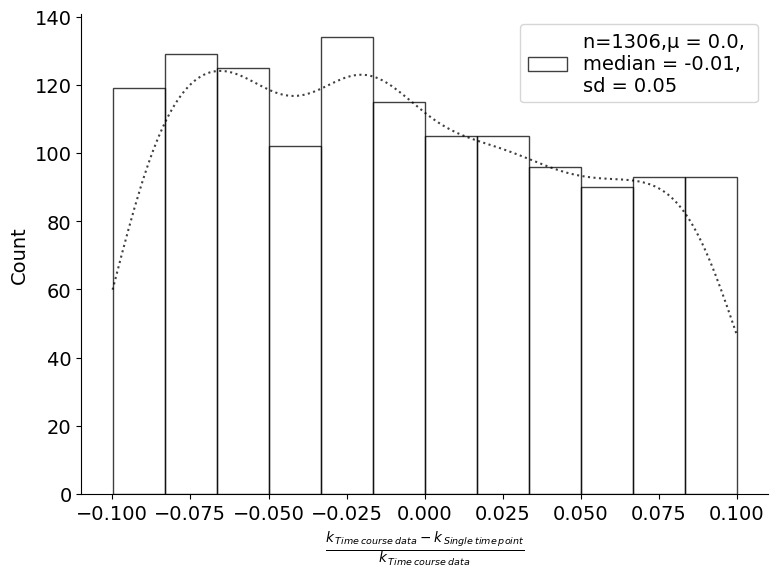

In [54]:
_res=allvals.copy()
# _res=_res[abs(_res['rd_fsr'] )<0.03]
_res=_res[abs(_res['error'] )<0.10]
_res=_res.reset_index(drop=True)


# plt.scatter(_res.i0_t_exp,y)
# plt.plot(_res.i0_t_exp,_res.i0_t_exp,c='r')

# plt.scatter(_res.fsr_exp,_res.fsr_d2ome)
plt.scatter(_res.fsr_exp,_res.fsr_new,c='k',alpha=0.4)
plt.plot(_res.fsr_exp,_res.fsr_exp,c='r')
plt.xlabel('FSR (exp)')
plt.ylabel('FSR (approx.)')
plt.savefig(f"{_path}/{_title}_fsr.jpeg",dpi=900)
plt.show()

sns.histplot(_res['rd_fsr'] )
plt.xlabel("Relative Difference (FSR)")


plot_hitmap(_res.d2ome_k,_res.new_k,_time,_path1,_title)

plotRateRDDensity(_res,_path1,_title)

In [34]:
# plt.scatter(_res.d2ome_k,_res.new_k)

In [35]:
# plt.plot(
#     [-math.log(1-i) for i in ((_res.I0_0_exp - _res.i0_t_exp)/(_res.M0 - _res.I0_asmp))],
#     [-math.log(1-i) for i in ((_res.I0_0_exp - _res.i0_t_exp)/(_res.M0 - _res.I0_asmp))]
# )
# plt.scatter(  
#             [-math.log(1-i) for i in ((_res.I0_0_exp - _res.i0_t_exp)/(_res.M0 - _res.I0_asmp))],
#             (_res.new_k*_time)
#             )

In [36]:
# plt.scatter( (_res.new_k*_time),((_res.I0_0_exp - _res.i0_t_exp)/(_res.M0 - _res.I0_asmp)) )

In [37]:
# _res